Reference: https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d

# Deep dive into feature selection and engineering

### Read in the Data

Read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
import numpy as np
import pandas as pd
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn import preprocessing

warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [15]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [16]:
#Change column name: 'y' to 'response'
df.rename(index=str, columns={'y': 'response'}, inplace = True)

### Understanding the Features
```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Feature Selection & Engineering

In machine learning, there are many levers that impact the performance of the model. In general, these include the following:

- The algorithm choice.
- The parameters used in the algorithm.
- The quantity and quality of the data set.
- The features used to train the model.

Goals of Feature Selection:

- Improve model accuracy.
- Reduce computational cost.
- Improve model interpretability.

In [17]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp.var.rate    41188 non-null  Float64
 16  cons.price.idx  41188 non-null  Float64
 17  cons.conf.idx   41188 non-null  Floa

In [18]:
# Checking for class imbalance
df['response'].value_counts()

no     36548
yes     4640
Name: response, dtype: Int64

In [19]:
df = df.apply(LabelEncoder().fit_transform)

# Feature Selection
Goal is to reduce the dimensionality of data

#### Technique-1 : Correlation Plot {To perform manual feature selection}

<AxesSubplot:>

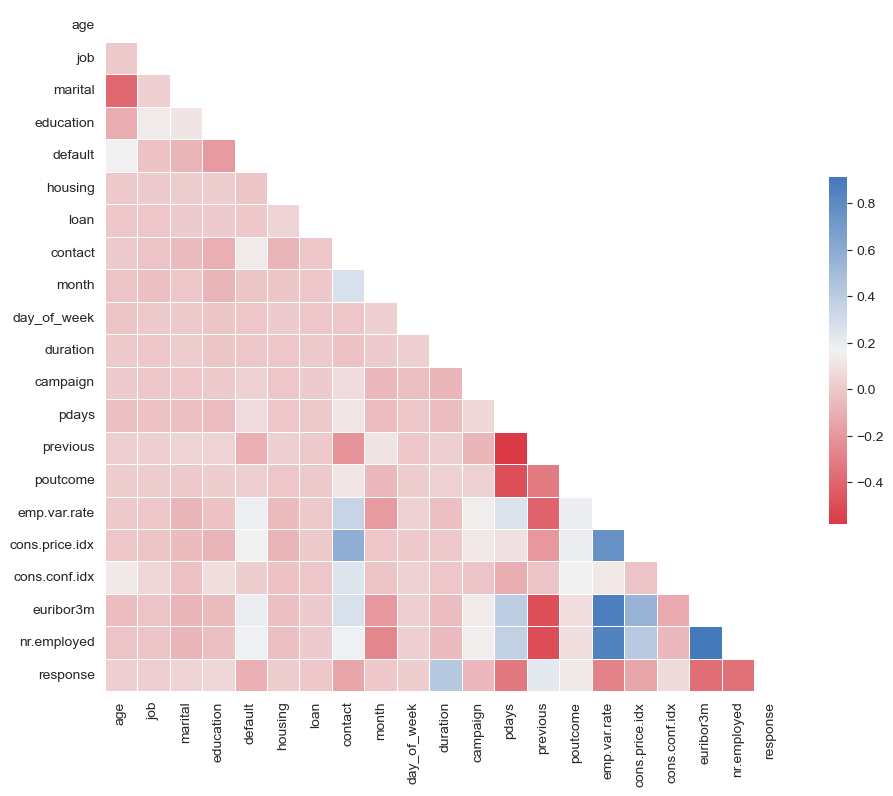

In [20]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True,linewidths=.5, 
            cbar_kws={"shrink": .5}, ax=ax)

Identify & remove features which are 
- closely correlated
e.g. keep one of the following features "emp.var.rate" & drop "nr.employed","euribor3m" & "cons.price.idx" because they are closely correlated

- low correlation with target
e.g. cam drop "pdays"

#### Technique-2 : Feature Importance

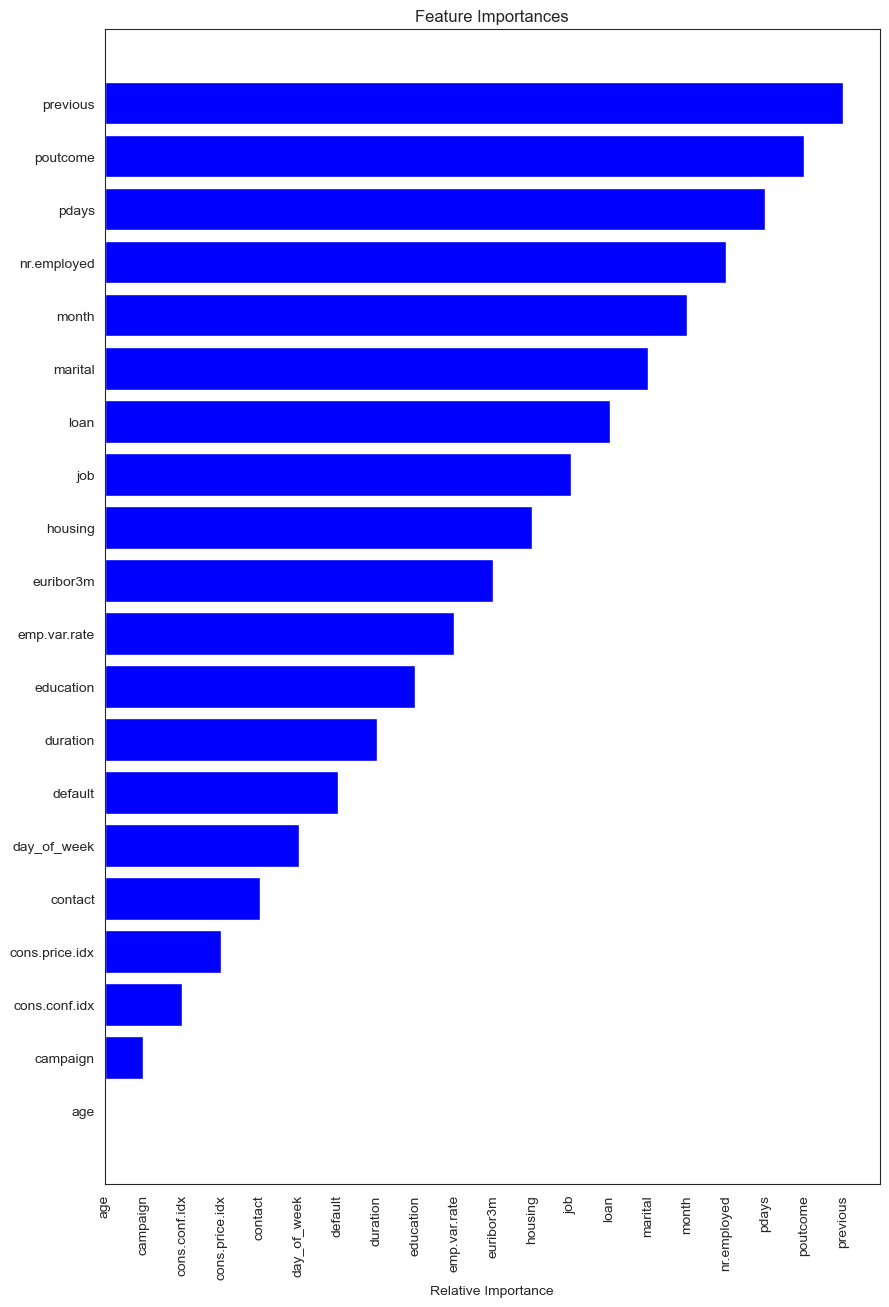

In [25]:
# Spliiting data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('response', axis=1), df['response'], 
                                                    test_size=0.20, random_state=42)

# fitting the model
model = LogisticRegression()
model.fit(X_train, y_train)

# plotting feature importances
features = df.drop('response', axis=1).columns
importances = model.feature_names_in_
indices = np.argsort(importances)

plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xticks(rotation=90)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Identify and remove less important features like campaign & some of the socio-economic indicators

#### Automated feature selection

In [28]:
# 1- variance threshold ( how far are the data points spread out for a given variable ?) 
# ... intution for breast cancer the gender is always going to be female

X = df.drop('response', axis=1)
selector = VarianceThreshold()
print("Original feature shape:", X.shape)
new_X = selector.fit_transform(X)
print("Transformed feature shape:", new_X.shape)

Original feature shape: (41188, 20)
Transformed feature shape: (41188, 20)


- Conclusion: The transformed dataset is of the same shape which means there is some variance in each of the feature ( default variance is 0 ) & hence the selector kept all the datapoints

In [30]:
#2 - univariate feature selection
X = df.drop('response', axis=1)
y = df['response']
selector = SelectKBest()
print("Original feature shape:", X.shape)
new_X = selector.fit_transform(X, y)
print("Transformed feature shape:", new_X.shape)

Original feature shape: (41188, 20)
Transformed feature shape: (41188, 10)


- Conclusion: Number of features dropped to 10.

In [ ]:
#3 - Recursive feature elimination
X_normalized = preprocessing.normalize(X, norm='l2') # required to scale the data for the estimator to work
y = y
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=2)
selector = selector.fit(X, y)
print("Features selected", selector.support_)
print("Feature ranking", selector.ranking_)

# Feature Engineering

Goal is to transform existing features and constructing new features to improve the performance of a model

In [ ]:
df['id'] = df.index + 1

In [ ]:
es = ft.EntitySet(id = 'df')
es.entity_from_dataframe(entity_id = 'df', dataframe = df, index = 'id')

In [ ]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
target_entity = 'df', 
max_depth = 2, 
verbose = 1, 
n_jobs = 3)